In [39]:
import pandas as pd
import getFamaFrenchFactors as gff
import copy
from sklearn.linear_model import LinearRegression, LogisticRegression
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import accuracy_score,f1_score,auc
from pandas_datareader.data import DataReader
from sklearn.preprocessing import StandardScaler
from factor_analyzer.factor_analyzer import FactorAnalyzer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neural_network import MLPClassifier

from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit

In [2]:
# FF 5 factor data
ff5_rf = pd.DataFrame(gff.famaFrench5Factor(frequency='m')).iloc[258:666,:]
ff5_rf = ff5_rf.reset_index(drop=True)
ff5_rf

,date_ff_factors,Mkt-RF,SMB,HML,RMW,CMA,RF
0,1985-01-31,0.0799,0.0351,-0.0535,-0.0089,-0.0341,0.0065
1,1985-02-28,0.0122,0.0104,-0.0010,0.0129,0.0106,0.0058
2,1985-03-31,-0.0084,-0.0139,0.0407,0.0123,0.0288,0.0062
3,1985-04-30,-0.0096,-0.0010,0.0372,0.0155,0.0071,0.0072
4,1985-05-31,0.0509,-0.0231,-0.0096,0.0133,-0.0149,0.0066
...,...,...,...,...,...,...,...
403,2018-08-31,0.0344,0.0063,-0.0399,-0.0029,-0.0265,0.0016
404,2018-09-30,0.0006,-0.0249,-0.0169,0.0064,0.0130,0.0015
405,2018-10-31,-0.0768,-0.0445,0.0344,0.0093,0.0359,0.0019
406,2018-11-30,0.0169,-0.0077,0.0027,-0.0055,0.0037,0.0018


In [3]:
# Drop column RF
ff5 = copy.deepcopy(ff5_rf)

ff5 = ff5.drop(columns=['RF'])
ff5 = ff5.iloc[:-1]
ff5

,date_ff_factors,Mkt-RF,SMB,HML,RMW,CMA
0,1985-01-31,0.0799,0.0351,-0.0535,-0.0089,-0.0341
1,1985-02-28,0.0122,0.0104,-0.0010,0.0129,0.0106
2,1985-03-31,-0.0084,-0.0139,0.0407,0.0123,0.0288
3,1985-04-30,-0.0096,-0.0010,0.0372,0.0155,0.0071
4,1985-05-31,0.0509,-0.0231,-0.0096,0.0133,-0.0149
...,...,...,...,...,...,...
402,2018-07-31,0.0319,-0.0193,0.0047,0.0156,0.0035
403,2018-08-31,0.0344,0.0063,-0.0399,-0.0029,-0.0265
404,2018-09-30,0.0006,-0.0249,-0.0169,0.0064,0.0130
405,2018-10-31,-0.0768,-0.0445,0.0344,0.0093,0.0359


In [4]:
# data of proxies
p = pd.read_excel('C:/Users/phy0901/Desktop/毕业论文/proxies.xlsx')
p = p.iloc[234:-1,:]

# fill nan with mean in each column
for col in p.columns:
    p[col] = p[col].fillna(p[col].mean())
p.index = ff5['date_ff_factors']
p = p.drop(['yearmo'],axis=1)
p

,pdnd,ripo,nipo,cefd,s,cci
date_ff_factors,,,,,,
1985-01-31,-18.307778,13.5,30,1.075966,0.166263,96.0
1985-02-28,-18.471050,19.6,26,3.424857,0.168626,93.7
1985-03-31,-17.410422,29.3,39,3.072688,0.159131,93.7
1985-04-30,-15.026079,7.0,40,3.241603,0.159640,94.6
1985-05-31,-14.184753,23.2,40,3.314112,0.158165,91.8
...,...,...,...,...,...,...
2018-07-31,-6.658086,21.5,25,6.874079,0.076442,97.9
2018-08-31,-9.615477,11.4,15,7.154746,0.078317,96.2
2018-09-30,-8.565910,26.1,24,7.452493,0.082428,100.1


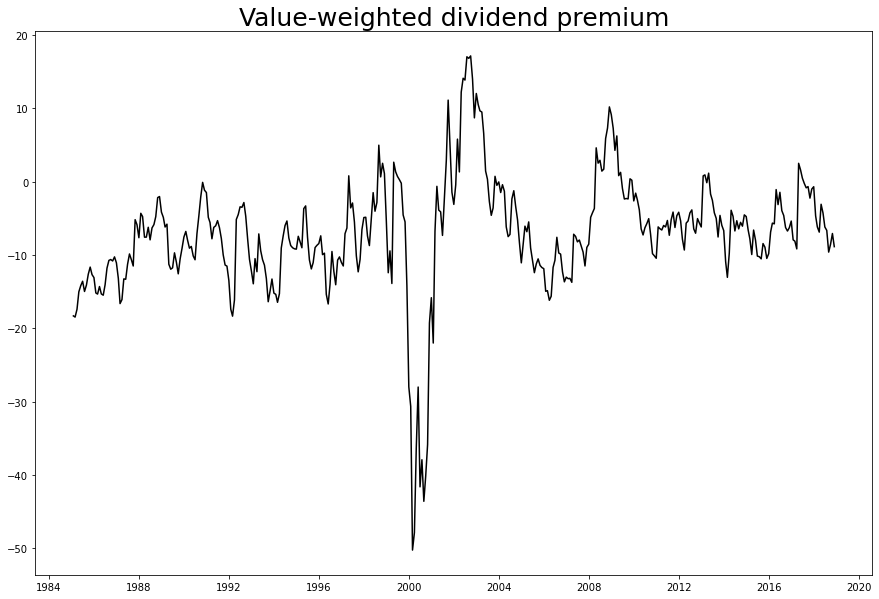

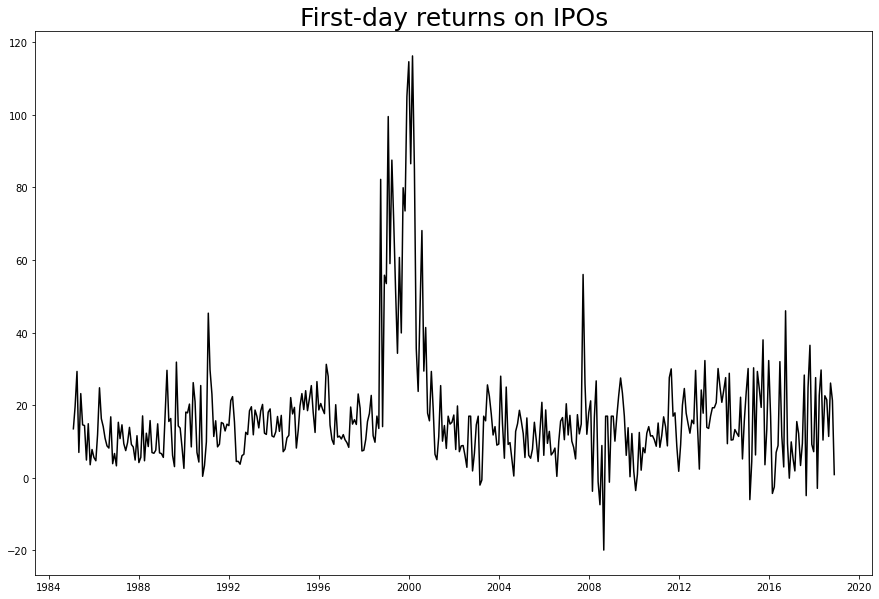

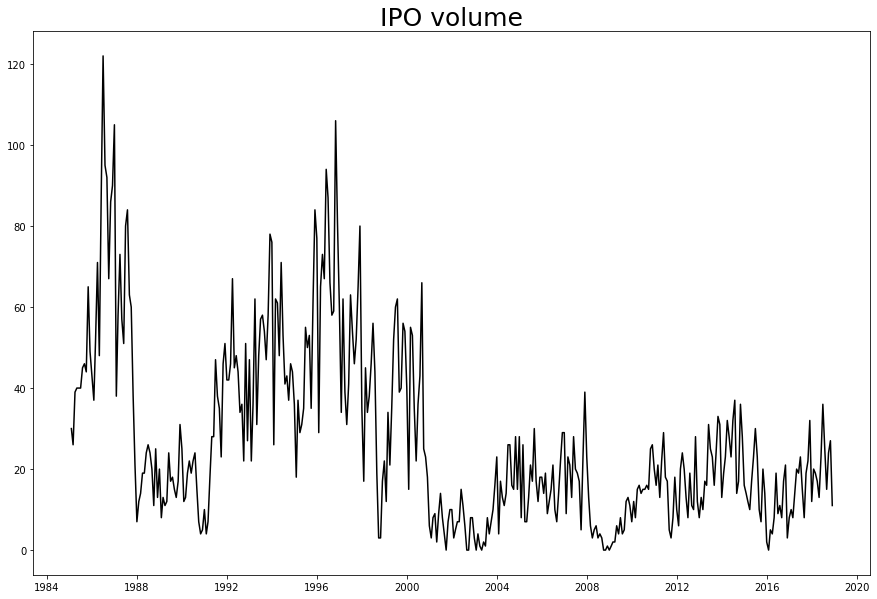

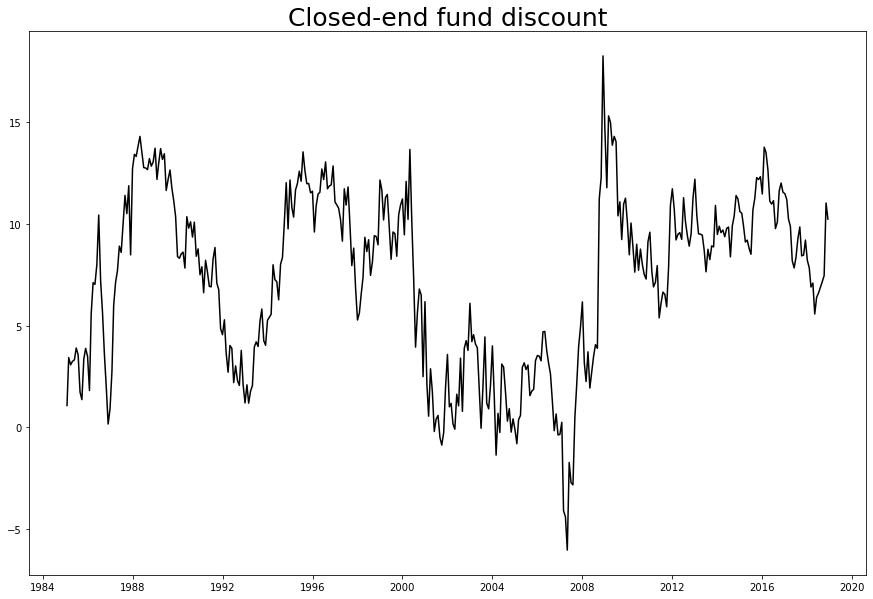

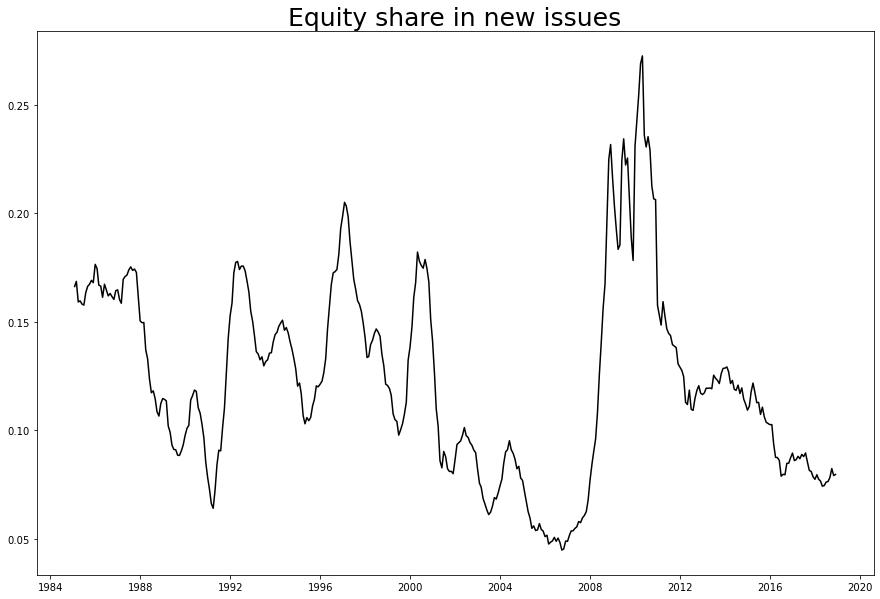

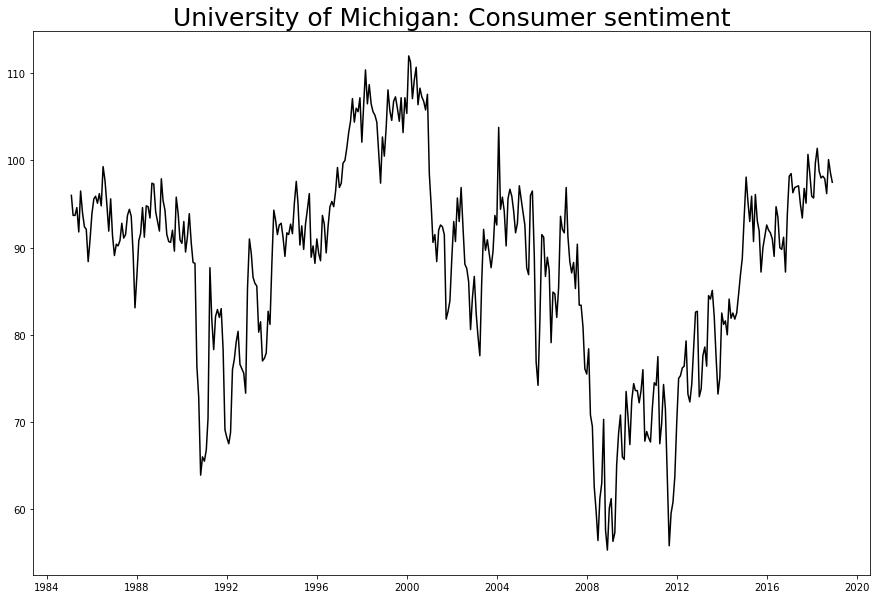

In [5]:
# Plots for proxies
plt_title = ['Value-weighted dividend premium','First-day returns on IPOs','IPO volume','Closed-end fund discount','Equity share in new issues','University of Michigan: Consumer sentiment']
for i in range(int(len(p.columns))):
    plt.figure(figsize=(15, 10))
    plt.plot(p[p.columns[i]], c='k',linewidth=1.5)   
    plt.title(plt_title[i],fontsize=25)
    plt.show()

In [6]:
# statistics for proxies
p.describe()

,pdnd,ripo,nipo,cefd,s,cci
count,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000
mean,-7.157396,16.984188,27.181818,7.249334,0.123195,88.084767
std,8.182621,16.330727,22.069893,4.264203,0.044852,11.701388
min,-50.233458,-19.900000,0.000000,-6.020000,0.044861,55.300000
25%,-10.692351,8.575000,11.000000,3.675000,0.088254,81.350000
50%,-6.836514,14.100000,20.000000,8.196996,0.118537,90.900000
75%,-3.633544,19.700000,38.500000,10.632392,0.155541,95.400000
max,17.128044,116.200000,122.000000,18.230000,0.272471,112.000000


In [7]:
# extract monthly stock closing price from Yahoo Finance
tickers = ['AAPL', 'AE', 'ALOT','AMAT', 'AMGN', 'BAM','BCV','BDL', 'BIO', 'BMI', 'BRN', 'CAMP', 'CASY', 'CBRL', 'CET', 'COKE', 'CSPI', 'CTAS', 'CVR', 'DINO', 'ESP', 'FONR', 'FRD', 'GHM', 'GRC', 'HCSG', 'HOV', 'IMO', 'JOB', 'KLAC', 'KTCC', 'LGL', 'LRCX', 'MGRC', 'MYE', 'NBR', 'PAYX', 'RELL','ROG', 'RRX', 'SEIC', 'SIF', 'SJW', 'SVT', 'TPC', 'VALU', 'WDFC']

price = pd.DataFrame()
for i in range(len(tickers)):
    a = DataReader(tickers[i],'yahoo','01/01/1985','01/01/2019')
    price[tickers[i]] = a.groupby(pd.Grouper(freq='M'))['Adj Close'].mean()
    

In [8]:
price

,AAPL,AE,ALOT,AMAT,AMGN,BAM,BCV,BDL,BIO,BMI,...,RELL,ROG,RRX,SEIC,SIF,SJW,SVT,TPC,VALU,WDFC
Date,,,,,,,,,,,,,,,,,,,,,
1985-01-31,0.101799,2.323293,1.225606,0.170902,0.084518,0.233053,2.030952,3.187922,2.212121,0.343442,...,4.418006,6.202840,1.441580,0.233795,2.345642,0.954871,3.668008,25.157279,4.823877,3.790974
1985-02-28,0.097751,2.590494,1.377705,0.190602,0.095277,0.249255,2.162386,3.381290,2.194932,0.379441,...,5.378237,7.318484,1.616456,0.277800,2.388888,1.132682,3.577900,24.805620,5.345616,4.114007
1985-03-31,0.079141,2.461663,1.450629,0.162424,0.086765,0.243225,2.157376,3.027436,2.333333,0.345200,...,5.569084,7.155666,1.541082,0.279685,2.332284,1.111379,3.541189,23.704094,4.934138,3.947076
1985-04-30,0.074564,2.322978,1.432877,0.150663,0.087233,0.237322,2.135722,3.266130,2.606702,0.317523,...,5.570316,6.410162,1.442873,0.297877,2.146785,1.222040,3.640322,24.582422,4.777935,3.442371
1985-05-31,0.068407,2.303436,1.712272,0.147756,0.111768,0.205268,2.107384,3.205010,3.329966,0.316661,...,5.603896,6.394753,1.531109,0.264321,2.021351,1.310687,4.737681,24.457751,4.591454,3.658877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31,51.332185,38.160240,18.504869,43.619271,174.562960,27.238013,14.354399,26.188515,318.827824,51.122093,...,7.916916,132.203043,75.271085,57.910741,5.197826,56.279816,10.244904,19.845652,21.096221,160.025682
2018-09-30,53.487298,38.677974,21.563478,37.473703,179.692067,27.430724,14.727324,25.570305,308.225258,52.309428,...,7.725037,145.345791,75.932328,59.274572,5.220526,54.481213,10.389474,20.028947,22.056726,166.371942
2018-10-31,53.191521,35.774009,19.547158,32.892534,176.265375,26.791225,13.809792,26.160079,283.850437,47.575596,...,7.062486,129.652608,70.232807,52.984171,5.050870,55.568326,10.095225,17.575652,22.262214,153.087160


In [9]:
# Calculate monthly return for 47 stocks
ret = pd.DataFrame()
for i in tickers:
    a = np.zeros(len(price)-1)
    for j in range(len(price)-1):
        
        a[j] = price[i][j+1]/ price[i][j]-1-ff5_rf['RF'][j+1]

        ret[i] = a

    

In [10]:
ret

,AAPL,AE,ALOT,AMAT,AMGN,BAM,BCV,BDL,BIO,BMI,...,RELL,ROG,RRX,SEIC,SIF,SJW,SVT,TPC,VALU,WDFC
0,-0.045572,0.109210,0.118301,0.109468,0.121495,0.063723,0.058915,0.054856,-0.013571,0.099019,...,0.211545,0.174060,0.115509,0.182422,0.012637,0.180414,-0.030366,-0.019778,0.102358,0.079411
1,-0.196578,-0.055932,0.046731,-0.154038,-0.095544,-0.030395,-0.008517,-0.110851,0.056855,-0.096442,...,0.029285,-0.028448,-0.052829,0.000585,-0.029895,-0.025008,-0.016460,-0.050606,-0.083175,-0.046776
2,-0.065037,-0.063538,-0.019437,-0.079605,-0.001808,-0.031468,-0.017237,0.071644,0.109958,-0.087375,...,-0.006979,-0.111384,-0.070928,0.057846,-0.086735,0.092371,0.020794,0.029854,-0.038858,-0.135068
3,-0.089173,-0.015013,0.188388,-0.025899,0.274665,-0.141667,-0.019869,-0.025313,0.270863,-0.009314,...,-0.000572,-0.009004,0.054553,-0.119250,-0.065029,0.065941,0.294846,-0.011672,-0.045629,0.056294
4,-0.171281,0.043925,-0.060310,-0.130085,0.042620,0.004807,0.007935,-0.057988,0.051957,0.016557,...,0.009832,0.014741,-0.062908,0.053041,0.003555,-0.001891,0.038441,0.022092,-0.032100,-0.044204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,0.122207,0.069165,0.026099,-0.011361,0.028736,0.030657,0.007024,-0.014445,0.050313,0.097103,...,-0.042276,0.114948,0.002175,-0.029558,-0.009558,-0.071170,0.090296,0.084982,0.048767,0.072647
403,0.040484,0.012067,0.163787,-0.142391,0.027883,0.005575,0.024480,-0.025106,-0.034755,0.021725,...,-0.025737,0.097913,0.007285,0.022051,0.002867,-0.033458,0.012611,0.007736,0.044030,0.038158
404,-0.007430,-0.076981,-0.095406,-0.124150,-0.020970,-0.025213,-0.064201,0.021165,-0.080981,-0.092397,...,-0.087667,-0.109871,-0.076961,-0.108023,-0.034398,0.018054,-0.030222,-0.124387,0.007416,-0.081750
405,-0.133640,-0.015101,-0.045955,0.015071,-0.017645,0.019251,-0.013765,-0.045427,-0.038538,0.060749,...,-0.120001,-0.056523,-0.006076,-0.035753,-0.044586,0.034246,0.054651,0.015408,0.017749,0.055294


# Sentiment Index Construction

In [11]:
# Standardize proxies
scaler = StandardScaler()
p_std=pd.DataFrame(scaler.fit_transform(p))
p_std.columns =['pdnd','ripo','nipo','cefd','s','cci']
p_std

,pdnd,ripo,nipo,cefd,s,cci
0,-1.364368,-0.213614,0.127851,-1.449501,0.961416,0.677268
1,-1.384346,0.160374,-0.053615,-0.897984,1.014145,0.480468
2,-1.254567,0.755078,0.536148,-0.980672,0.802208,0.480468
3,-0.962817,-0.612127,0.581514,-0.941011,0.813572,0.557477
4,-0.859872,0.381089,0.581514,-0.923986,0.780626,0.317894
...,...,...,...,...,...,...
402,0.061096,0.276863,-0.098981,-0.088110,-1.043666,0.839842
403,-0.300772,-0.342364,-0.552645,-0.022209,-1.001805,0.694381
404,-0.172347,0.558887,-0.144348,0.047701,-0.910041,1.028085
405,0.009462,0.264601,-0.008248,0.883584,-0.982063,0.899737


In [14]:
# (1) KMO test
kmo_all,kmo_model=calculate_kmo(p_std)
print(kmo_model)


0.5199274967683997


In [15]:
# (2) Bartlett's Test

chi_square_value,p_value=calculate_bartlett_sphericity(p_std)
chi_square_value, p_value 



(413.9624924862012, 8.024043933754097e-79)

In [16]:
# PCA
fa = FactorAnalyzer(p_std.shape[1], rotation=None)  # Input the number of factors to select
fa.fit(p_std)

ev, v = fa.get_eigenvalues() # Calculate the The original eigen values and The common factor eigen values
                             # Normally, we just need ev which is the eigenvalues from the original correlation matrix
                             # The common factor eigen value is calculated from the adjusted correlation matrix whose diagonal is replaced by communalities
var, prot_var, acc_var = fa.get_factor_variance()# Output The factor variances, The proportional factor variances and The cumulative factor variances.
prot_var

array([0.2631517 , 0.1741196 , 0.08719495, 0.04263459, 0.00128467,
       0.        ])

In [17]:
# accumulated variance
acc_var

array([0.2631517 , 0.43727131, 0.52446626, 0.56710085, 0.56838552,
       0.56838552])

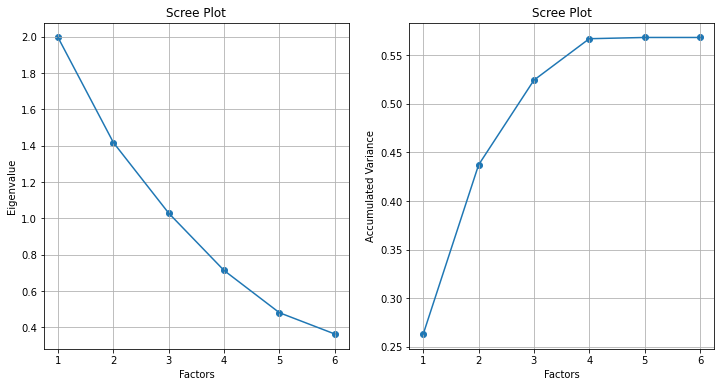

In [18]:
# scree plots
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(range(1,p_std.shape[1]+1),ev) # Here, we just let the plot starting point is 1 rather than 0, representing the first factor
plt.plot(range(1,p_std.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()

plt.subplot(1,2,2)
plt.scatter(range(1,p_std.shape[1]+1),acc_var) # Here, we just let the plot starting point is 1 rather than 0, representing the first factor
plt.plot(range(1,p_std.shape[1]+1),acc_var)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Accumulated Variance')
plt.grid()
plt.show()

In [19]:
# Use the first three principal components

fa = FactorAnalyzer(3, rotation="varimax")
fa.fit(p_std)

# Output the loading of these 2 PCs, these means the correlation of 5 variables to the new 2 PCs
df_loading = pd.DataFrame(fa.loadings_, index=p_std.columns)
df_loading.index=['pdnd','ripo','nipo','cefd','s','cci']
df_loading.columns =['PC1', 'PC2', 'PC3']
df_loading 

,PC1,PC2,PC3
pdnd,-0.575206,-0.095354,-0.219922
ripo,0.198723,0.102052,0.924400
nipo,0.744560,0.218776,-0.088279
cefd,0.005030,0.351086,0.143958
s,0.150392,0.981648,-0.146642
cci,0.527303,-0.225506,0.267269


In [20]:
# Calculate coefficient for each proxy to build the sentiment index
p_std.columns = p.columns
av1 = acc_var[0]/acc_var[2]
av2 = (acc_var[1]-acc_var[0])/acc_var[2]
av3 = (acc_var[2]-acc_var[1])/acc_var[2]

coeff = np.zeros(6)
for i in range(6):
    coeff[i] = df_loading.iloc[i,0]*av1 + df_loading.iloc[i,1]*av2 + df_loading.iloc[i,2]*av3
coeff

array([-0.35683012,  0.28727633,  0.4315397 ,  0.14301607,  0.37698082,
        0.23414304])

In [21]:
# construct dataframe for sentiment index 
import copy
p_fac = copy.deepcopy(p_std)
for i in range(6):
    p_fac.iloc[:,i] = coeff[i]*p_std.iloc[:,i]
sent = pd.DataFrame()
sent['Sent'] = np.zeros(len(p_fac))
for i in range(len(p_fac)):
    sent['Sent'][i] = p_fac.iloc[i,:].sum()
sent.index = ff5['date_ff_factors']

In [22]:
sent

,Sent
date_ff_factors,
1985-01-31,0.794365
1985-02-28,0.883297
1985-03-31,1.170616
1985-04-30,0.721310
1985-05-31,0.903822
...,...
2018-07-31,-0.194379
2018-08-31,-0.447770
2018-09-30,0.064235


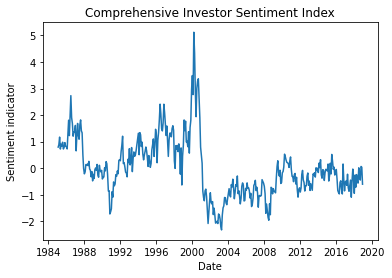

In [23]:
# plot time series of sent
plt.plot(sent)
plt.xlabel("Date")
plt.ylabel("Sentiment indicator")
plt.title('Comprehensive Investor Sentiment Index')
plt.show()

# Granger's Causality Test

In [24]:
# extract closing price data of S&P 500
price_sp500 = DataReader('^GSPC','yahoo','01/01/1985','01/01/2019')
price_sp500 = price_sp500.groupby(pd.Grouper(freq='M'))['Adj Close'].mean()

# calculate the monthly return
ret_sp500 = np.zeros(len(price_sp500)-1)
for j in range(len(ret_sp500)):
    ret_sp500[j] = price_sp500[j+1]/ price_sp500[j]-1-ff5_rf['RF'][j+1]


In [25]:
# ADF test for sent
result = adfuller(sent['Sent'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


# https://machinelearningmastery.com/time-series-data-stationary-python/

ADF Statistic: -3.490424
p-value: 0.008236
Critical Values:
	1%: -3.447
	5%: -2.869
	10%: -2.571


In [26]:
# ADF test for return of S&P 500
result = adfuller(ret_sp500)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -13.116164
p-value: 0.000000
Critical Values:
	1%: -3.447
	5%: -2.869
	10%: -2.571


In [27]:
# Granger Causality Test
from statsmodels.tsa.stattools import grangercausalitytests
gc = pd.DataFrame()
gc['sent'] = sent['Sent']
gc['ret'] = ret_sp500
#perform Granger-Causality test
grangercausalitytests(gc[['sent', 'ret']], maxlag=[1])


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=43.7916 , p=0.0000  , df_denom=403, df_num=1
ssr based chi2 test:   chi2=44.1176 , p=0.0000  , df=1
likelihood ratio test: chi2=41.8812 , p=0.0000  , df=1
parameter F test:         F=43.7916 , p=0.0000  , df_denom=403, df_num=1


{1: ({'ssr_ftest': (43.791611620807345, 1.1663199533862557e-10, 403.0, 1),
   'ssr_chi2test': (44.117603766867944, 3.092274340994416e-11, 1),
   'lrtest': (41.88122667353366, 9.69893900413068e-11, 1),
   'params_ftest': (43.7916116208074, 1.1663199533861978e-10, 403.0, 1.0)},
   array([[0., 1., 0.]])])}

# Regression

In [28]:
# independent variables for MFFS
ff6 = copy.deepcopy(ff5)
ff6['sent'] = list(sent['Sent'])
ff6

,date_ff_factors,Mkt-RF,SMB,HML,RMW,CMA,sent
0,1985-01-31,0.0799,0.0351,-0.0535,-0.0089,-0.0341,0.794365
1,1985-02-28,0.0122,0.0104,-0.0010,0.0129,0.0106,0.883297
2,1985-03-31,-0.0084,-0.0139,0.0407,0.0123,0.0288,1.170616
3,1985-04-30,-0.0096,-0.0010,0.0372,0.0155,0.0071,0.721310
4,1985-05-31,0.0509,-0.0231,-0.0096,0.0133,-0.0149,0.903822
...,...,...,...,...,...,...,...
402,2018-07-31,0.0319,-0.0193,0.0047,0.0156,0.0035,-0.194379
403,2018-08-31,0.0344,0.0063,-0.0399,-0.0029,-0.0265,-0.447770
404,2018-09-30,0.0006,-0.0249,-0.0169,0.0064,0.0130,0.064235
405,2018-10-31,-0.0768,-0.0445,0.0344,0.0093,0.0359,0.035893


In [29]:
# data split
X1 = ff5.iloc[:,1:]
X2 = ff6.iloc[:,1:]
y = ret

# Standardize features by removing the mean and scaling to unit variance

x_train1 = X1.iloc[:306,:]
x_train2 = X2.iloc[:306,:]
x_test1 = X1.iloc[306:,:]
x_test2 = X2.iloc[306:,:]
y_train = y.iloc[:306,:]
y_test = y.iloc[306:,:]

# standardize independent varaibles
scaler = StandardScaler()
x_train_std1 = scaler.fit_transform(x_train1)
x_test_std1 = scaler.fit_transform(x_test1)
x_train_std2 = scaler.fit_transform(x_train2)
x_test_std2 = scaler.fit_transform(x_test2)

## OLS

In [59]:
# OLS
ols = LinearRegression()
pred_ols1 = pd.DataFrame()
pred_ols2 = pd.DataFrame()
sent_coef_ols = pd.DataFrame()

# loop over 47 stocks
# MFF
for i in tickers:
    ols.fit(x_train_std1, y_train[i])
    pred_ols1[i] = ols.predict(x_test_std1)

# MFFS
for i in tickers:
    ols.fit(x_train_std2, y_train[i])
    pred_ols2[i] = ols.predict(x_test_std2)
    sent_coef_ols[i] = ols.coef_


In [54]:
# feature importance of models for 47 stocks
sent_coef_ols

,AAPL,AE,ALOT,AMAT,AMGN,BAM,BCV,BDL,BIO,BMI,...,RELL,ROG,RRX,SEIC,SIF,SJW,SVT,TPC,VALU,WDFC
0,0.027977,0.017679,0.022422,0.042039,0.008736,0.035631,0.016778,0.013294,0.034026,0.028004,...,0.042977,0.023002,0.032039,0.030194,0.049525,0.010573,0.019984,0.039921,0.019177,0.016990
1,-0.003822,0.017899,0.016439,0.002374,-0.002673,0.005825,0.000779,0.021787,0.012137,0.014657,...,0.024882,0.005671,0.008859,-0.000421,0.015684,-0.005605,0.014177,0.029983,0.013823,0.006115
2,-0.005304,0.001932,0.010681,-0.004399,-0.019840,0.014957,0.006164,0.015257,-0.002173,-0.003814,...,-0.000048,-0.007484,0.008526,0.008752,0.005635,0.006013,0.005644,0.022019,0.004268,0.004265
3,-0.009271,0.004412,-0.005056,-0.003465,0.008679,0.007582,-0.002172,0.005035,0.007490,0.016212,...,-0.001923,0.002522,0.006533,0.002467,0.012944,-0.007259,0.005966,0.012156,0.005475,0.004980
4,-0.018946,0.002863,-0.009918,-0.008974,-0.010936,-0.006359,-0.005713,-0.019865,0.005731,-0.007291,...,0.004902,0.005335,-0.002398,-0.015978,0.003150,-0.002168,-0.011963,-0.021451,-0.004219,-0.004345
5,-0.013662,0.005135,-0.015596,-0.000067,0.003601,-0.004861,-0.000605,-0.005262,-0.007083,-0.004485,...,0.002155,0.004450,-0.005426,0.006582,-0.004409,-0.000695,-0.011443,-0.011601,-0.003308,-0.003538


<Figure size 1800x720 with 0 Axes>

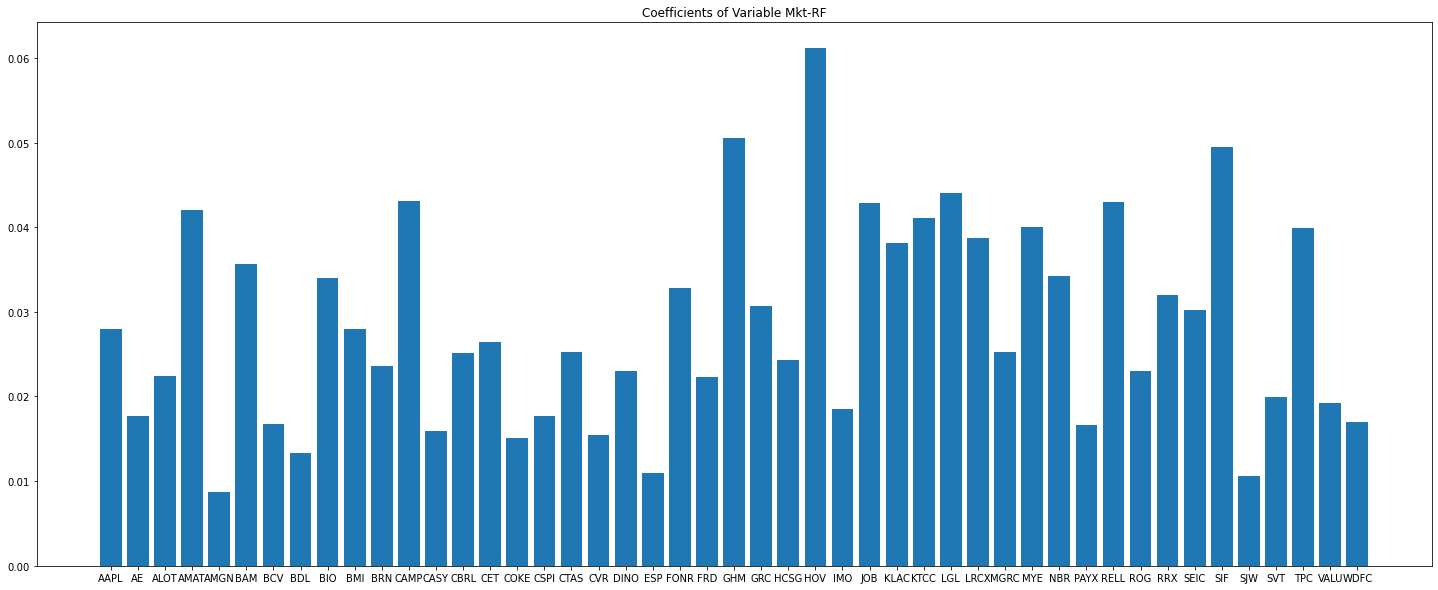

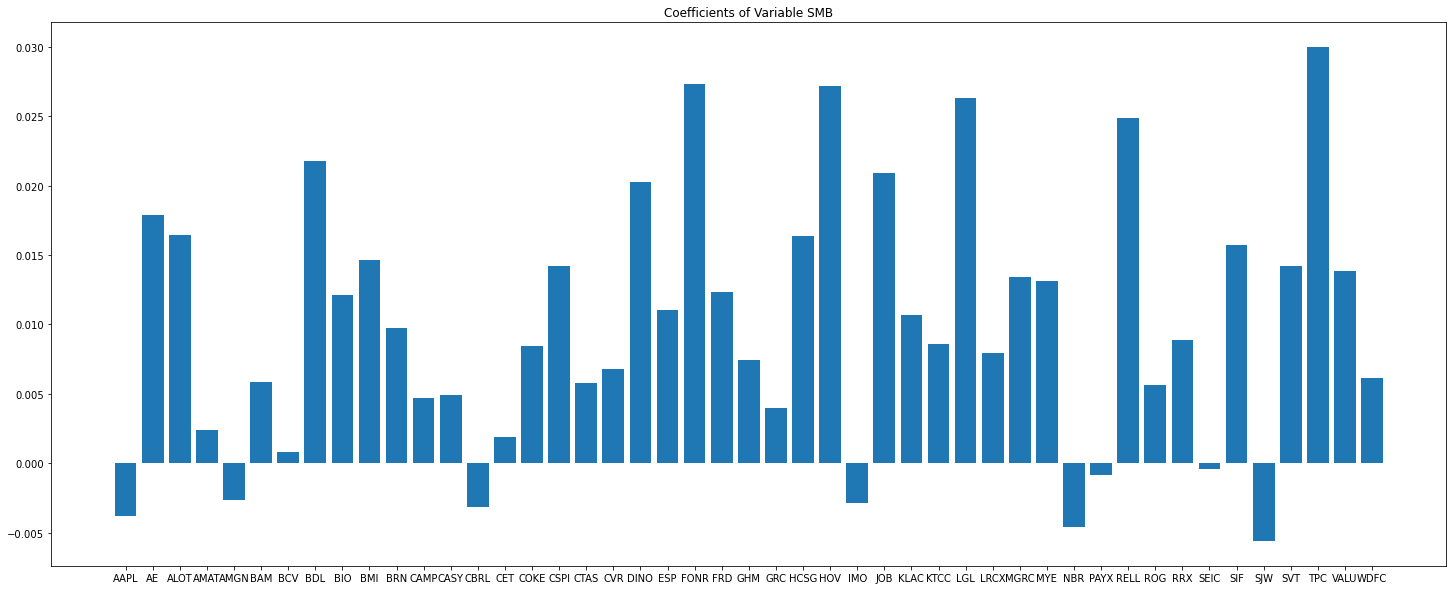

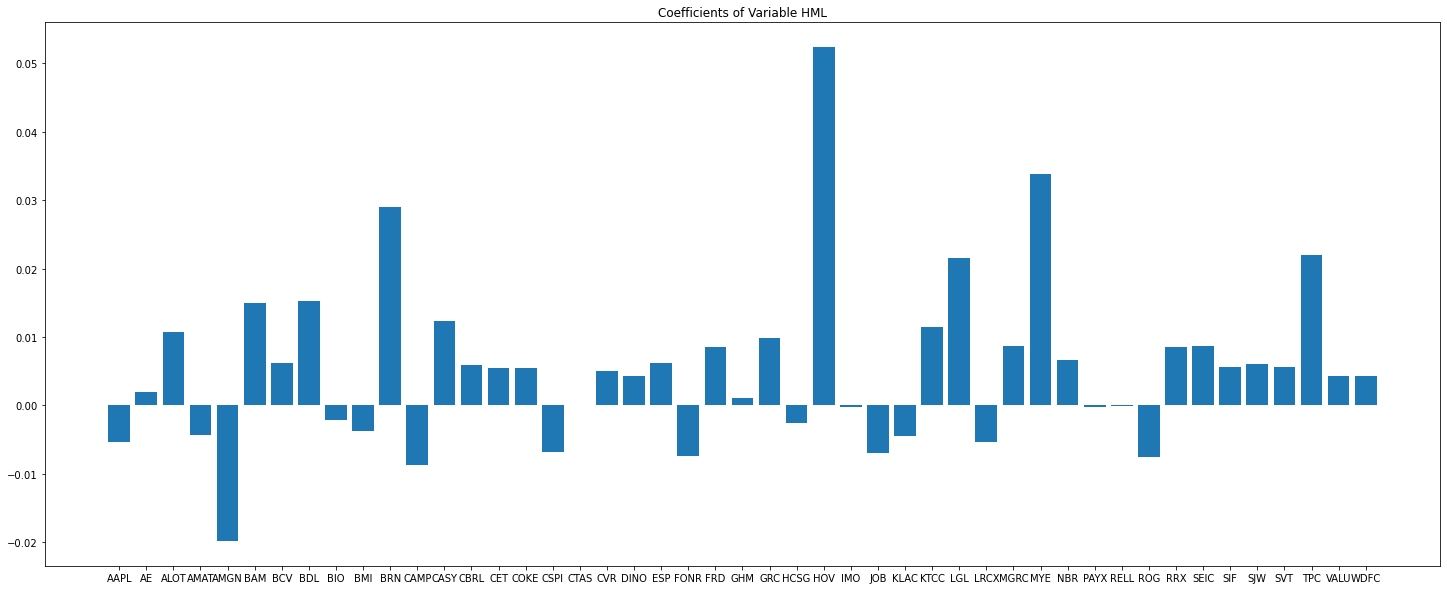

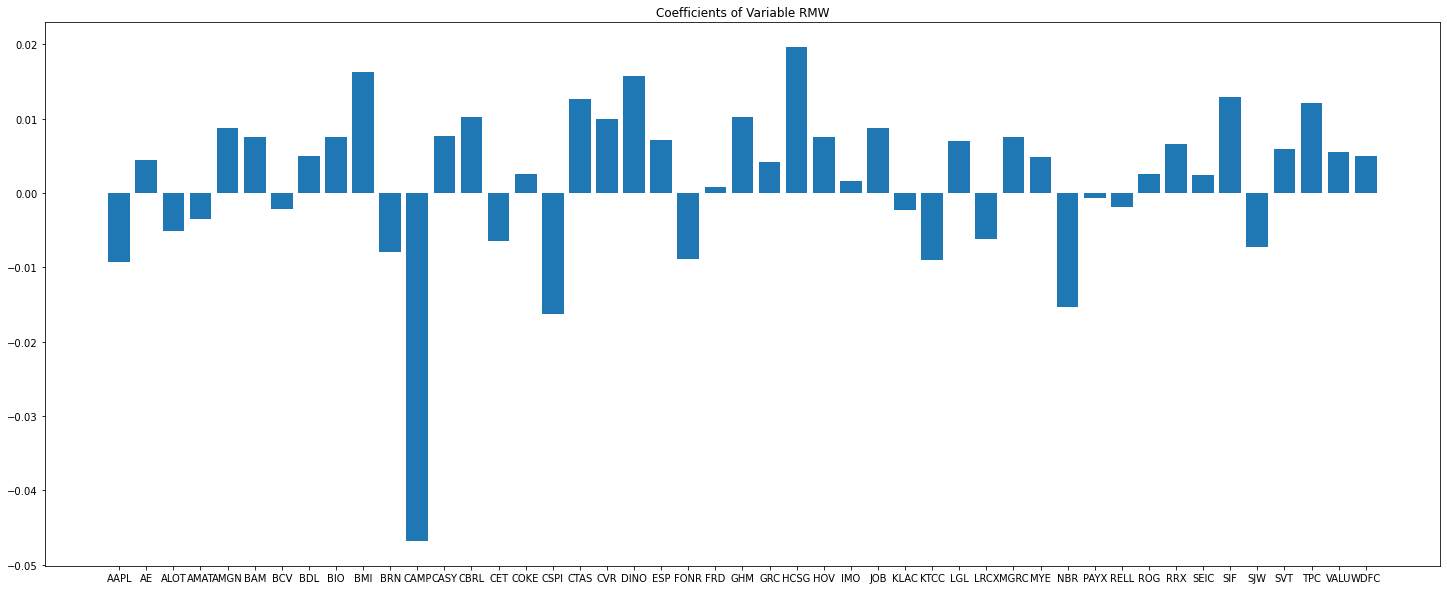

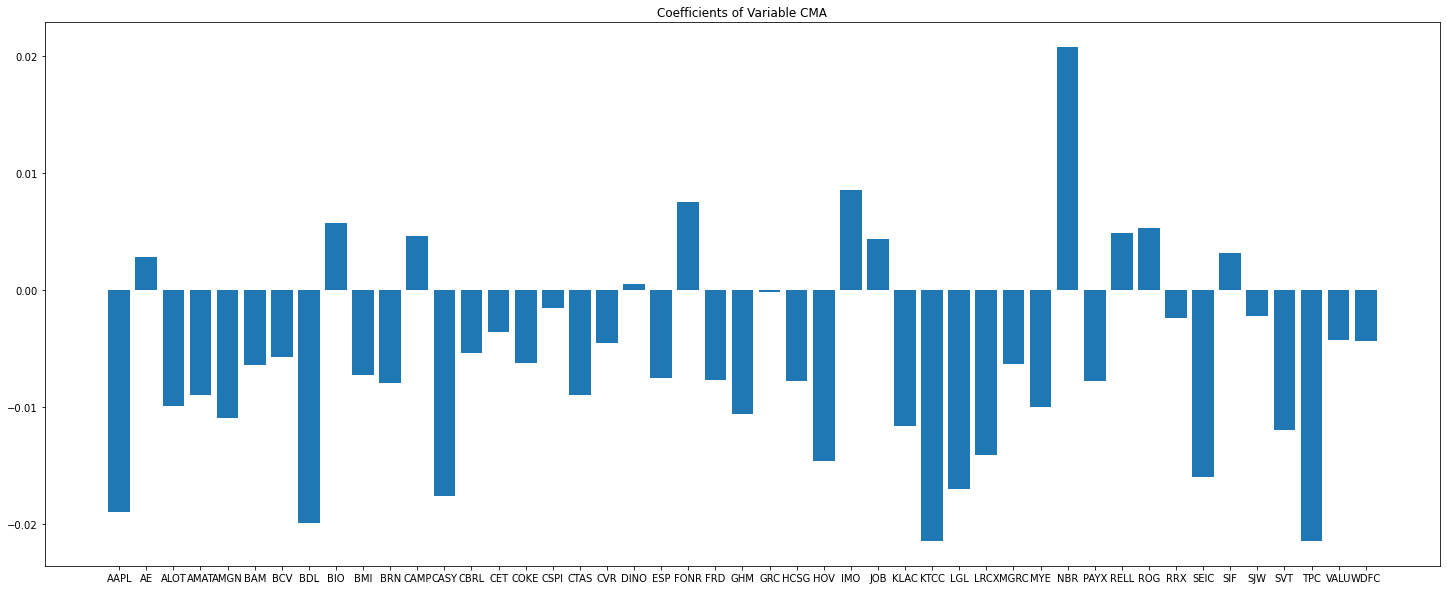

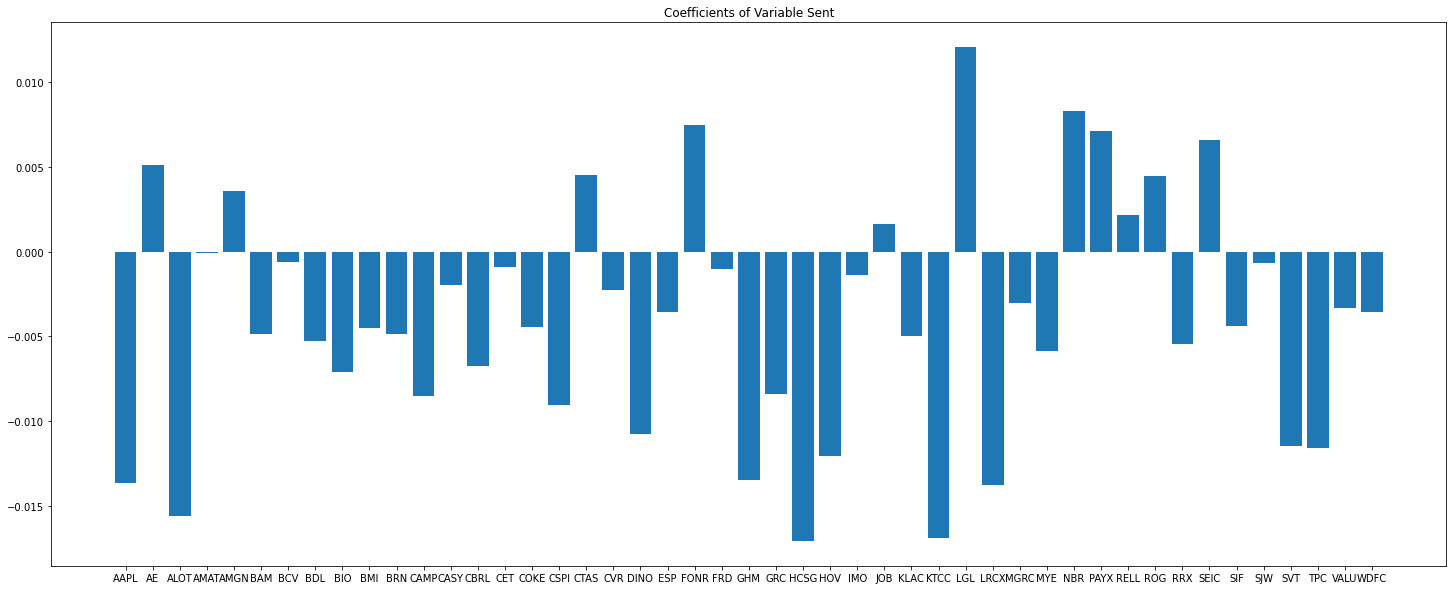

In [55]:
# plot feature importance
plt.figure(figsize=(25, 10))
features=['Mkt-RF','SMB','HML','RMW','CMA','Sent']
for i in range(6):
    plt.figure(figsize=(25, 10))
    plt.bar(tickers,sent_coef_ols.iloc[i,:])
    plt.title('Coefficients of Variable '+ features[i])
    plt.show()

## XGBoost

In [61]:
# XGBoost
mp_xgb1 = pd.DataFrame()
mp_xgb2 = pd.DataFrame()

depth_xgb = pd.DataFrame()
xgboost = xgb.XGBRegressor()
params_xgb = {'max_depth' : [1,2,3,4,5,6,7,8,9,10]}
tscv = TimeSeriesSplit(n_splits=5)
gs_xgb = GridSearchCV(xgboost, params_xgb, cv=tscv)

# hyperparameter tuning
# MFF
for i in tickers:
    gs_xgb.fit(x_train_std1, y_train[i])
    n = gs_xgb.best_params_
    mp_xgb1[i] = [n['max_depth']]

# MFFS
for i in tickers:
    gs_xgb.fit(x_train_std2, y_train[i])
    n = gs_xgb.best_params_
    mp_xgb2[i] = [n['max_depth']]

In [62]:
# use optimized hyperparameters to do prediction
pred_xgb1 = pd.DataFrame()
pred_xgb2 = pd.DataFrame()

# MFF
for i in tickers:
    xgb_best = xgb.XGBRegressor(max_depth= int(mp_xgb1[i]))
    xgb_best.fit(x_train_std1, y_train[i])
    pred_xgb1[i] = xgb_best.predict(x_test_std1)

# MFFS
for i in tickers:
    xgb_best = xgb.XGBRegressor(max_depth=int(mp_xgb2[i]))
    xgb_best.fit(x_train_std2, y_train[i])
    pred_xgb2[i] = xgb_best.predict(x_test_std2)
    

In [63]:
# Use metrics MAE, RMSE and R2 score to measure the performance of prediction models
mae = pd.DataFrame()
rmse = pd.DataFrame()
r2 = pd.DataFrame()

# OLS
mae['ols without sent'] = np.zeros(47)
mae['ols with sent'] = np.zeros(47)
rmse['ols without sent'] = np.zeros(47)
rmse['ols with sent'] = np.zeros(47)
r2['ols without sent'] = np.zeros(47)
r2['ols with sent'] = np.zeros(47)

for j in range(47):

    mae['ols without sent'][j] = mean_absolute_error(y_test[tickers[j]], pred_ols1[tickers[j]])
    mae['ols with sent'][j] = mean_absolute_error(y_test[tickers[j]], pred_ols2[tickers[j]])
    rmse['ols without sent'][j] = np.sqrt(mean_squared_error(y_test[tickers[j]], pred_ols1[tickers[j]]))
    rmse['ols with sent'][j] = np.sqrt(mean_squared_error(y_test[tickers[j]], pred_ols2[tickers[j]]))
    r2['ols without sent'][j] = r2_score(y_test[tickers[j]], pred_ols1[tickers[j]])
    r2['ols with sent'][j] = r2_score(y_test[tickers[j]], pred_ols2[tickers[j]])


In [64]:
# XGBoost metric scores
mae['XGBoost without sent'] = np.zeros(47)
mae['XGBoost with sent'] = np.zeros(47)
rmse['XGBoost without sent'] = np.zeros(47)
rmse['XGBoost with sent'] = np.zeros(47)
r2['XGBoost without sent'] = np.zeros(47)
r2['XGBoost with sent'] = np.zeros(47)

for j in range(47):

    mae['XGBoost without sent'][j] = mean_absolute_error(y_test[tickers[j]], pred_xgb1[tickers[j]])
    mae['XGBoost with sent'][j] = mean_absolute_error(y_test[tickers[j]], pred_xgb2[tickers[j]])
    rmse['XGBoost without sent'][j] = np.sqrt(mean_squared_error(y_test[tickers[j]], pred_xgb1[tickers[j]]))
    rmse['XGBoost with sent'][j] = np.sqrt(mean_squared_error(y_test[tickers[j]], pred_xgb2[tickers[j]]))
    r2['XGBoost without sent'][j] = r2_score(y_test[tickers[j]], pred_xgb1[tickers[j]])
    r2['XGBoost with sent'][j] = r2_score(y_test[tickers[j]], pred_xgb2[tickers[j]])

# assign index names
mae.index=tickers
rmse.index=tickers
r2.index=tickers

In [65]:
# Calculate the percentage that MFFS perform better
prob_reg = pd.DataFrame()
prob_reg['OLS'] = np.zeros(3)
prob_reg['XGBoost'] = np.zeros(3)

prob_reg['OLS'][0] = list(mae['ols with sent'] < mae['ols without sent']).count(True)/47
prob_reg['OLS'][1] = list(rmse['ols with sent'] < rmse['ols without sent']).count(True)/47
prob_reg['OLS'][2] = list(r2['ols with sent'] > r2['ols without sent']).count(True)/47
prob_reg['XGBoost'][0] = list(mae['XGBoost with sent'] < mae['XGBoost without sent']).count(True)/47
prob_reg['XGBoost'][1] = list(rmse['XGBoost with sent'] < rmse['XGBoost without sent']).count(True)/47
prob_reg['XGBoost'][2] = list(r2['XGBoost with sent'] > r2['XGBoost without sent']).count(True)/47

prob_reg.index=['MAE','RMSE','R2 score']


In [66]:
prob_reg

,OLS,XGBoost
MAE,0.340426,0.404255
RMSE,0.319149,0.425532
R2 score,0.319149,0.425532


In [67]:
# statistics for MAE
mae.describe()

,ols without sent,ols with sent,XGBoost without sent,XGBoost with sent
count,47.000000,47.000000,47.000000,47.000000
mean,0.058958,0.059255,0.064510,0.066456
std,0.023800,0.023760,0.025831,0.027584
min,0.022309,0.022240,0.024800,0.024744
25%,0.042398,0.042500,0.046379,0.047744
50%,0.053047,0.053769,0.057569,0.059826
75%,0.068256,0.068706,0.073019,0.076922
max,0.142660,0.142709,0.146864,0.147424


In [68]:
# statistics for RMSE
rmse.describe()

,ols without sent,ols with sent,XGBoost without sent,XGBoost with sent
count,47.000000,47.000000,47.000000,47.000000
mean,0.080702,0.081041,0.087735,0.089915
std,0.044336,0.044118,0.046048,0.047307
min,0.028774,0.028709,0.031509,0.031448
25%,0.054910,0.055877,0.058293,0.060205
50%,0.066530,0.067358,0.073063,0.076568
75%,0.093623,0.092754,0.099084,0.102184
max,0.298827,0.298732,0.303635,0.303548


In [69]:
# statistics for R2 score
r2.describe()

,ols without sent,ols with sent,XGBoost without sent,XGBoost with sent
count,47.000000,47.000000,47.000000,47.000000
mean,-0.148783,-0.164073,-0.383490,-0.443607
std,0.177593,0.187459,0.290202,0.309886
min,-0.622215,-0.683330,-1.126527,-1.245039
25%,-0.236563,-0.261070,-0.584682,-0.583707
50%,-0.134931,-0.142556,-0.380225,-0.371017
75%,-0.002682,-0.002325,-0.146941,-0.227714
max,0.112235,0.105806,0.043328,0.023634


In [70]:
# means by different metrics for OLS and XGBoost to compare two algorithms
mean_reg = pd.DataFrame()
mean_reg['OLS'] = np.zeros(3)
mean_reg['XGBoost'] = np.zeros(3)

mean_reg['OLS'][0] = np.mean([np.mean(mae['ols without sent']), np.mean(mae['ols with sent'])])
mean_reg['OLS'][1] = np.mean([np.mean(rmse['ols without sent']), np.mean(rmse['ols with sent'])])
mean_reg['OLS'][2] = np.mean([np.mean(r2['ols without sent']), np.mean(r2['ols with sent'])])
mean_reg['XGBoost'][0] = np.mean([np.mean(mae['XGBoost without sent']), np.mean(mae['XGBoost with sent'])])
mean_reg['XGBoost'][1] = np.mean([np.mean(rmse['XGBoost without sent']), np.mean(rmse['XGBoost with sent'])])
mean_reg['XGBoost'][2] = np.mean([np.mean(r2['XGBoost without sent']), np.mean(r2['XGBoost with sent'])])

mean_reg.index=['MAE','RMSE','R2 score']

In [71]:
mean_reg

,OLS,XGBoost
MAE,0.059106,0.065483
RMSE,0.080871,0.088825
R2 score,-0.156428,-0.413548


# Classification

In [72]:
# 1 represents positive return, and 0 represnets zero or negative return
ret_sign = copy.deepcopy(ret)
for i in tickers:
    
    for j in range(len(ret)):
        if ret[i][j] >= 0:
            ret_sign[i][j] = 1
        else: 
            ret_sign[i][j] = 0
            
ret_sign

,AAPL,AE,ALOT,AMAT,AMGN,BAM,BCV,BDL,BIO,BMI,...,RELL,ROG,RRX,SEIC,SIF,SJW,SVT,TPC,VALU,WDFC
0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
403,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
405,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0


In [73]:
X1 = ff5_rf.iloc[:407,1:6]
X2 = ff6.iloc[:407,1:]
y = ret_sign

# Standardize features by removing the mean and scaling to unit variance

x_train1 = X1.iloc[:306,:]
x_train2 = X2.iloc[:306,:]
x_test1 = X1.iloc[306:,:]
x_test2 = X2.iloc[306:,:]
y_train = y.iloc[:306,:]
y_test = y.iloc[306:,:]


scaler = StandardScaler()
x_train_std1 = scaler.fit_transform(x_train1)
x_test_std1 = scaler.fit_transform(x_test1)
x_train_std2 = scaler.fit_transform(x_train2)
x_test_std2 = scaler.fit_transform(x_test2)

## Logistic regression

In [75]:
# Logistic regression
lr1 = LogisticRegression(penalty='l2',  C=1.0, fit_intercept=True, solver='lbfgs', max_iter=100,  verbose=0)
lr2 = LogisticRegression(penalty='l2',  C=1.0, fit_intercept=True, solver='lbfgs', max_iter=100,  verbose=0)

pred_lr1 = pd.DataFrame()
pred_lr2 = pd.DataFrame()



coeff_lr1 = pd.DataFrame()
coeff_lr2 = pd.DataFrame()
intercept_lr1 = np.zeros(47)
intercept_lr2 = np.zeros(47)

# loop over 47 stocks

# MFF
for i in tickers:  
    lr1.fit(x_train_std1, y_train[i])
    pred_lr1[i] = lr1.predict(x_test_std1)
    
# MFFS   
for i in tickers:
    lr2.fit(x_train_std2, y_train[i])
    pred_lr2[i] = lr2.predict(x_test_std2)
  


## XGBoost classification

In [76]:
# XGBoost
from xgboost import XGBClassifier
xgb1 = XGBClassifier(max_depth=5, 
                     min_child_weight = 4, 
                     eta = 0.02,
                     gamma=0, 
                     cv=10)
xgb2 = XGBClassifier(max_depth=5, 
                     min_child_weight = 4, 
                     eta = 0.02,
                     gamma=0, 
                     cv=10)

# loop over 47 stocks
# MFF
for i in tickers:
    xgb1.fit(x_train_std1, y_train[i])
    pred_xgb1[i] = xgb1.predict(x_test_std1)
    
# MFFS
for i in tickers:
    xgb2.fit(x_train_std2, y_train[i])
    pred_xgb2[i] = xgb2.predict(x_test_std2)


C:\Users\phy0901\anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:50:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "cv" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:50:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "cv" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost

[12:51:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "cv" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:51:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:51:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "cv" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost

[12:51:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "cv" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:51:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:51:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "cv" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost

[12:51:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "cv" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:51:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:51:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "cv" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost

[12:51:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "cv" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:51:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:51:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "cv" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost

[12:51:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "cv" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:51:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:51:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "cv" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost

[12:51:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "cv" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:51:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:51:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "cv" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost

[12:51:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "cv" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:51:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:51:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "cv" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost

## SVM

In [77]:
from sklearn import svm
svm1 = svm.SVC(C=1.0, kernel='rbf',  gamma='auto')
svm2 = svm.SVC(C=1.0, kernel='rbf',  gamma='auto')
pred_svm1 = pd.DataFrame()
pred_svm2 = pd.DataFrame()

# loop over 47 stocks

# MFF
for i in tickers:
    svm1.fit(x_train_std1, y_train[i])
    pred_svm1[i] = svm1.predict(x_test_std1)

# MFFS
for i in tickers:
    svm2.fit(x_train_std2, y_train[i])
    pred_svm2[i] = svm2.predict(x_test_std2)

In [78]:
# Accuracy, F1-score and AUC are used to mearsure the prediction accuracy for logistic regression

acc = pd.DataFrame()
f1 = pd.DataFrame()
auc_score = pd.DataFrame()

acc['logreg without sent'] = np.zeros(47)
acc['logreg with sent'] = np.zeros(47)

f1['logreg without sent'] = np.zeros(47)
f1['logreg with sent'] = np.zeros(47)

auc_score['logreg without sent'] = np.zeros(47)
auc_score['logreg with sent'] = np.zeros(47)

for j in range(47):

    acc['logreg without sent'][j] = accuracy_score(y_test[tickers[j]], pred_lr1[tickers[j]])
    acc['logreg with sent'][j] = accuracy_score(y_test[tickers[j]], pred_lr2[tickers[j]])
    f1['logreg without sent'][j] = f1_score(y_test[tickers[j]], pred_lr1[tickers[j]])
    f1['logreg with sent'][j] = f1_score(y_test[tickers[j]], pred_lr2[tickers[j]])
    fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test[tickers[j]], pred_lr1[tickers[j]])
    fpr2, tpr2, thresholds2 = metrics.roc_curve(y_test[tickers[j]], pred_lr2[tickers[j]])

    auc_score['logreg without sent'][j] = auc(fpr1,tpr1)
    auc_score['logreg with sent'][j] = auc(fpr2,tpr2)

In [79]:
# Accuracy, F1-score and AUC are used to mearsure the prediction accuracy for XGBoost

acc['XGBoost without sent'] = np.zeros(47)
acc['XGBoost with sent'] = np.zeros(47)

f1['XGBoost without sent'] = np.zeros(47)
f1['XGBoost with sent'] = np.zeros(47)

auc_score['XGBoost without sent'] = np.zeros(47)
auc_score['XGBoost with sent'] = np.zeros(47)

for j in range(47):

    acc['XGBoost without sent'][j] = accuracy_score(y_test[tickers[j]], pred_xgb1[tickers[j]])
    acc['XGBoost with sent'][j] = accuracy_score(y_test[tickers[j]], pred_xgb2[tickers[j]])
    f1['XGBoost without sent'][j] = f1_score(y_test[tickers[j]], pred_xgb1[tickers[j]])
    f1['XGBoost with sent'][j] = f1_score(y_test[tickers[j]], pred_xgb2[tickers[j]])
    fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test[tickers[j]], pred_xgb1[tickers[j]])
    fpr2, tpr2, thresholds2 = metrics.roc_curve(y_test[tickers[j]], pred_xgb2[tickers[j]])
    auc_score['XGBoost without sent'][j] = auc(fpr1,tpr1)
    auc_score['XGBoost with sent'][j] = auc(fpr2,tpr2)
    
# Name the index
acc.index=tickers    
f1.index=tickers    
auc_score.index=tickers

In [80]:
# Accuracy, F1-score and AUC are used to mearsure the prediction accuracy for SVM

acc['SVM without sent'] = np.zeros(47)
acc['SVM with sent'] = np.zeros(47)

f1['SVM without sent'] = np.zeros(47)
f1['SVM with sent'] = np.zeros(47)

auc_score['SVM without sent'] = np.zeros(47)
auc_score['SVM with sent'] = np.zeros(47)

for j in range(47):

    acc['SVM without sent'][j] = accuracy_score(y_test[tickers[j]], pred_svm1[tickers[j]])
    acc['SVM with sent'][j] = accuracy_score(y_test[tickers[j]], pred_svm2[tickers[j]])
    f1['SVM without sent'][j] = f1_score(y_test[tickers[j]], pred_svm1[tickers[j]])
    f1['SVM with sent'][j] = f1_score(y_test[tickers[j]], pred_svm2[tickers[j]])
    fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test[tickers[j]], pred_svm1[tickers[j]])
    fpr2, tpr2, thresholds2 = metrics.roc_curve(y_test[tickers[j]], pred_svm2[tickers[j]])
    auc_score['SVM without sent'][j] = auc(fpr1,tpr1)
    auc_score['SVM with sent'][j] = auc(fpr2,tpr2)
acc.index=tickers
f1.index=tickers
auc_score.index=tickers


In [81]:
# Percentage of outperformed MFFSs

prob_clf = pd.DataFrame()
prob_clf['logreg'] = np.zeros(3)
prob_clf['XGBoost'] = np.zeros(3)
prob_clf['SVM'] = np.zeros(3)


prob_clf['logreg'][0] = list(acc['logreg with sent'] > acc['logreg without sent']).count(True)/47
prob_clf['logreg'][1] = list(f1['logreg with sent'] > f1['logreg without sent']).count(True)/47
prob_clf['logreg'][2] = list(auc_score['logreg with sent'] > auc_score['logreg without sent']).count(True)/47

prob_clf['XGBoost'][0] = list(acc['XGBoost with sent'] > acc['XGBoost without sent']).count(True)/47
prob_clf['XGBoost'][1] = list(f1['XGBoost with sent'] > f1['XGBoost without sent']).count(True)/47
prob_clf['XGBoost'][2] = list(auc_score['XGBoost with sent'] > auc_score['XGBoost without sent']).count(True)/47

prob_clf['SVM'][0] = list(acc['SVM with sent'] > acc['SVM without sent']).count(True)/47
prob_clf['SVM'][1] = list(f1['SVM with sent'] > f1['SVM without sent']).count(True)/47
prob_clf['SVM'][2] = list(auc_score['SVM with sent'] > auc_score['SVM without sent']).count(True)/47


prob_clf.index=['Accuracy','F1-score','AUC']
prob_clf

,logreg,XGBoost,SVM
Accuracy,0.382979,0.382979,0.425532
F1-score,0.468085,0.489362,0.489362
AUC,0.489362,0.446809,0.446809


In [82]:
# Mean of different metric scores to compare 3 algorithms
mean_clf = pd.DataFrame()
mean_clf['logreg'] = np.zeros(3)
mean_clf['XGBoost'] = np.zeros(3)
mean_clf['SVM'] = np.zeros(3)


mean_clf['logreg'][0] = np.mean([np.mean(acc['logreg without sent']), np.mean(acc['logreg with sent'])])
mean_clf['logreg'][1] = np.mean([np.mean(f1['logreg without sent']), np.mean(f1['logreg with sent'])])
mean_clf['logreg'][2] = np.mean([np.mean(auc_score['logreg without sent']), np.mean(auc_score['logreg with sent'])])

mean_clf['XGBoost'][0] = np.mean([np.mean(acc['XGBoost without sent']), np.mean(acc['XGBoost with sent'])])
mean_clf['XGBoost'][1] = np.mean([np.mean(f1['XGBoost without sent']), np.mean(f1['XGBoost with sent'])])
mean_clf['XGBoost'][2] = np.mean([np.mean(auc_score['XGBoost without sent']), np.mean(auc_score['XGBoost with sent'])])

mean_clf['SVM'][0] = np.mean([np.mean(acc['SVM without sent']), np.mean(acc['SVM with sent'])])
mean_clf['SVM'][1] = np.mean([np.mean(f1['SVM without sent']), np.mean(f1['SVM with sent'])])
mean_clf['SVM'][2] = np.mean([np.mean(auc_score['SVM without sent']), np.mean(auc_score['SVM with sent'])])


mean_clf.index=['Accuracy','F1-score','AUC']
mean_clf

,logreg,XGBoost,SVM
Accuracy,0.568780,0.553507,0.558247
F1-score,0.588297,0.578408,0.576455
AUC,0.552037,0.541423,0.536199


# Portfolio strategy

In [83]:
# Define the function for pertfolio generating strategy
def construct_port(predreg,predclf,y_test,tickers):
    port_ret = np.zeros(len(predreg))

    for i in range(len(predreg)):
        a = pd.DataFrame(predreg.iloc[i])
        b = pd.DataFrame(predclf.iloc[i])
        c = copy.deepcopy(a)
        for j in range(len(tickers)):
            if (a.iloc[j][i]<0)|(b.iloc[j][i] == 0.0):
                c = c.drop(tickers[j])
        # select 10 sctocks with top 10 predicted returns by regression
        if len(c) >= 10:
            rank = c.rank()
            
            rank = pd.DataFrame(c.rank(ascending=False))
            rank = rank.drop(rank[rank.iloc[:,0]>10].index)
            port_tickers = list(rank.index)
            port_ret[i] = np.mean(y_test[port_tickers].iloc[i])
        elif len(c) > 0:
            port_tickers = list(c.index)
            port_ret[i] = np.mean(y_test[port_tickers].iloc[i])
        else:
            port_ret[i] = 0
    return port_ret


        

In [84]:
# y_test here are the level stock returns
y = ret
y_test = y.iloc[306:,:]

In [86]:
# time series of portfolio return
port_ret1 = construct_port(pred_ols1,pred_lr1,y_test,tickers)
port_ret2 = construct_port(pred_ols2,pred_lr2,y_test,tickers)

In [87]:
# cumulative return
cum_ret1 = (1+port_ret1).cumprod()-1
cum_ret2 = (1+port_ret2).cumprod()-1


In [88]:
# the return of equal weighted portfolio including all the 47 stocks, and it is set to be a benchmark
bm_ret = np.zeros(len(y_test))
for i in range(len(y_test)):
    bm_ret[i] = np.mean(y_test.iloc[i])


In [89]:
# calculate the cumulative return for the portfolio with all 47 stocks
cum_bm = (1+bm_ret).cumprod()-1

In [90]:
# annualized Sharpe Ratio for the portfolio based on MFF
(port_ret1.mean()*12**0.5)/np.std(port_ret1)

1.7811737796247784

In [91]:
# annualized Sharpe Ratio for the portfolio based on MFFS

(port_ret2.mean()*12**0.5)/np.std(port_ret1)

1.8458357185953305

In [92]:
# annualized Sharpe Ratio for the portfolio based on the benchmark

(bm_ret.mean()*12**0.5)/np.std(port_ret1)

0.9012700094782554

In [93]:
# risk of P-MFF
np.std(port_ret1)*12**0.5

0.14942839163523164

In [94]:
# risk of P-MFFS
np.std(port_ret2)*12**0.5

0.17477509958398882

In [95]:
# risk of benchmark
np.std(bm_ret)*12**0.5

0.1183356001369257

In [96]:
# the final cumulative return of P-MFF
cum_ret1[-1]

7.377645805921759

In [97]:
# the final cumulative return of P-MFFS

cum_ret2[-1]

7.817488600663312

In [98]:
# the final cumulative return of the benchmark

cum_bm[-1]

1.9110363719686618

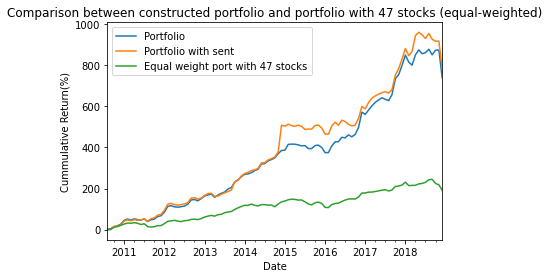

In [99]:
# plot of time series of cumulative returns of 3 portfolios
compRet = pd.DataFrame({'Portfolio': cum_ret1*100 ,'Portfolio with sent': cum_ret2*100, 'Equal weight port with 47 stocks': cum_bm*100})
compRet.index = ff5_rf['date_ff_factors'][307:408]
compRet.plot()
plt.legend(loc='upper left')
plt.xlabel("Date")
plt.ylabel("Cummulative Return(%)")
plt.title('Comparison between constructed portfolio and portfolio with 47 stocks (equal-weighted)')
plt.show()